## DAS4Orcas visualization and test notebook

In [1]:
# pip install autoreload if not installed
# import autoreload
# %load_ext autoreload
# %autoreload 2
# Imports
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
import das4whales as dw # Import the das4whales library, if not installed refer to https://das4whales.readthedocs.io/en/latest/src/install.html
plt.rcParams['font.size'] = 16

In [2]:
# filepath = 'data/decimator_2024-10-25_23.44.00_UTC_006608.h5'
# filename = 'decimator_22024-10-25_23.44.00_UTC_006608.h5'

# filepath = 'data/decimator_2024-10-29_20.26.00_UTC_012170.h5'
# filename = 'decimator_2024-10-29_20.26.00_UTC_012170.h5'

# filepath = 'data/decimator_2024-10-25_23.46.00_UTC_006610.h5'
# filename = 'decimator_22024-10-25_23.46.00_UTC_006610.h5'

# filepath = 'data/decimator_2024-10-25_23.47.00_UTC_006611.h5'
# filename = 'decimator_22024-10-25_23.47.00_UTC_006611.h5'

# filepath = 'data/decimator_2024-10-25_23.48.00_UTC_006612.h5'
# filename = 'decimator_22024-10-25_23.48.00_UTC_006612.h5'

# filepath = 'data/decimator_2024-10-25_23.49.00_UTC_006613.h5'
# filename = 'decimator_22024-10-25_23.49.00_UTC_006613.h5'

In [3]:
filepath = 'data/decimator_2025-07-21_19.00.00_UTC_126827.h5'
filename = 'decimator_2025-07-21_19.00.00_UTC_126827.h5'

In [4]:
# Read HDF5 files and access metadata
# Get the acquisition parameters for the data folder
metadata = dw.data_handle.get_acquisition_parameters(filepath, interrogator='onyx')
fs, dx, nx, ns, gauge_length, scale_factor = metadata["fs"], metadata["dx"], metadata["nx"], metadata["ns"], metadata["GL"], metadata["scale_factor"]

print(f'Sampling frequency: {metadata["fs"]} Hz')
print(f'Channel spacing: {metadata["dx"]} m')
print(f'Gauge length: {metadata["GL"]} m')
print(f'File duration: {metadata["ns"] / metadata["fs"]} s')
print(f'Cable max distance: {metadata["nx"] * metadata["dx"]/1e3:.1f} km')
print(f'Number of channels: {metadata["nx"]}')
print(f'Number of time samples: {metadata["ns"]}')

1.15e-07
Sampling frequency: 200.0 Hz
Channel spacing: 3.1904762684013206 m
Gauge length: 4.785714402601981 m
File duration: 33.12 s
Cable max distance: 6.1 km
Number of channels: 1904
Number of time samples: 6624


In [5]:
selected_channels_m_north = [0, 6000, 3.2]  # list of values in meters corresponding to the starting,
                                                # ending and step wanted channels along the FO Cable
                                                # selected_channels_m = [ChannelStart_m, ChannelStop_m, ChannelStep_m]
                                                # in meters

                                                # ### Select the desired channels and channel interval

selected_channels = [int(selected_channels_m // dx) for selected_channels_m in
                selected_channels_m_north]  # list of values in channel number (spatial sample) corresponding to the starting, ending and step wanted
                                        # channels along the FO Cable
                                        # selected_channels = [ChannelStart, ChannelStop, ChannelStep] in channel
                                        # numbers

print('Begin channel #:', selected_channels[0], 
', End channel #: ',selected_channels[1], 
', step: ',selected_channels[2], 
'equivalent to ',selected_channels[2]*dx,' m')

Begin channel #: 0 , End channel #:  1880 , step:  1 equivalent to  3.1904762684013206  m


In [6]:
tr, time, dist, fileBeginTimeUTC = dw.data_handle.load_das_data(filepath, selected_channels, metadata)
metadata["fileBeginTimeUTC"] = fileBeginTimeUTC.strftime("%Y-%m-%d_%H:%M:%S")

In [7]:
# Bandpass the data between 0.1 and 1 Hz
b, a = sp.butter(4, [5,95], 'bp', fs=fs)
# b, a = sp.butter(2, 30, 'high', fs=fs)
tr = sp.filtfilt(b, a, tr, axis=1)

In [8]:
# Useful commands to free memory (jupyter notebook does not free memory after a cell is executed)
import gc
gc.collect()

20

In [9]:
# Adapt the scale of the data to the plot
min_tr = np.min(tr)
max_tr = np.max(tr)
scale = np.min([np.abs(min_tr), np.abs(max_tr)]) * 0.001

## Plot the bandpass filtered data

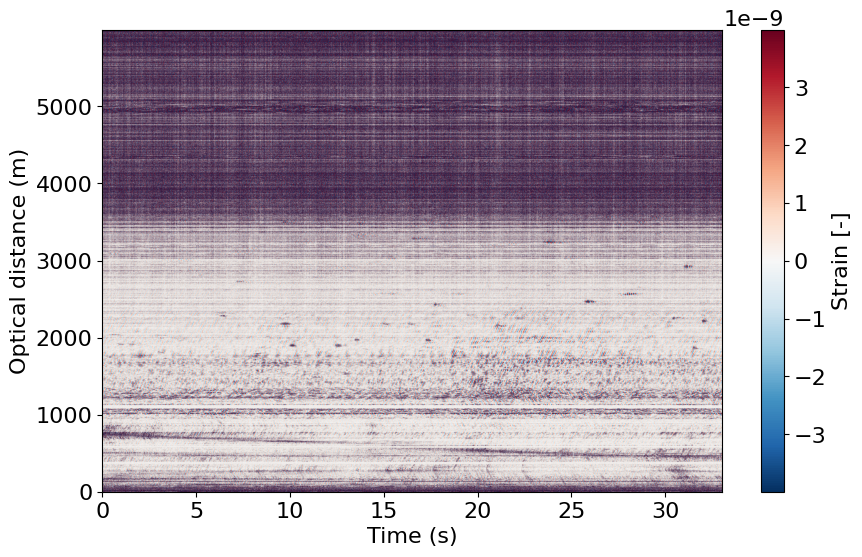

In [10]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.imshow(tr, origin='lower', aspect='auto', cmap='RdBu_r', extent=[0, time[-1], dist[0], dist[-1]], vmin=-scale, vmax=scale)
plt.ylabel('Optical distance (m)')
plt.xlabel('Time (s)')
# plt.ylim(3500,4000)
# plt.xlim(45, 52)
plt.colorbar(label='Strain [-]')
plt.show()

# dw.plot.plot_rawdata(tr*5e2, time, dist, fig_size=(10, 6))

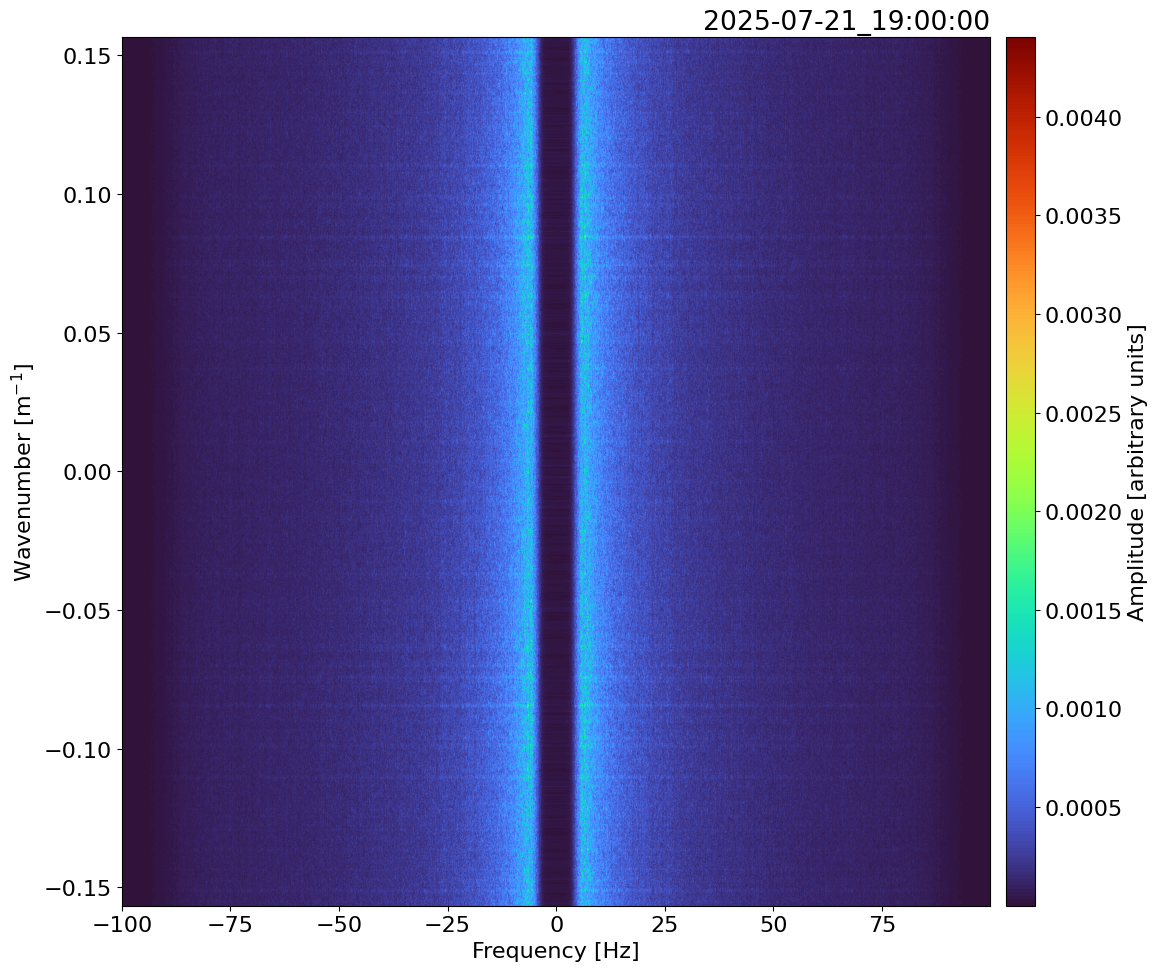

In [11]:
# Plot the fk spectrum
dw.plot.plot_fk_domain(tr, fs, dx, selected_channels, title_time_info=metadata["fileBeginTimeUTC"])

## F-K Filter the data  

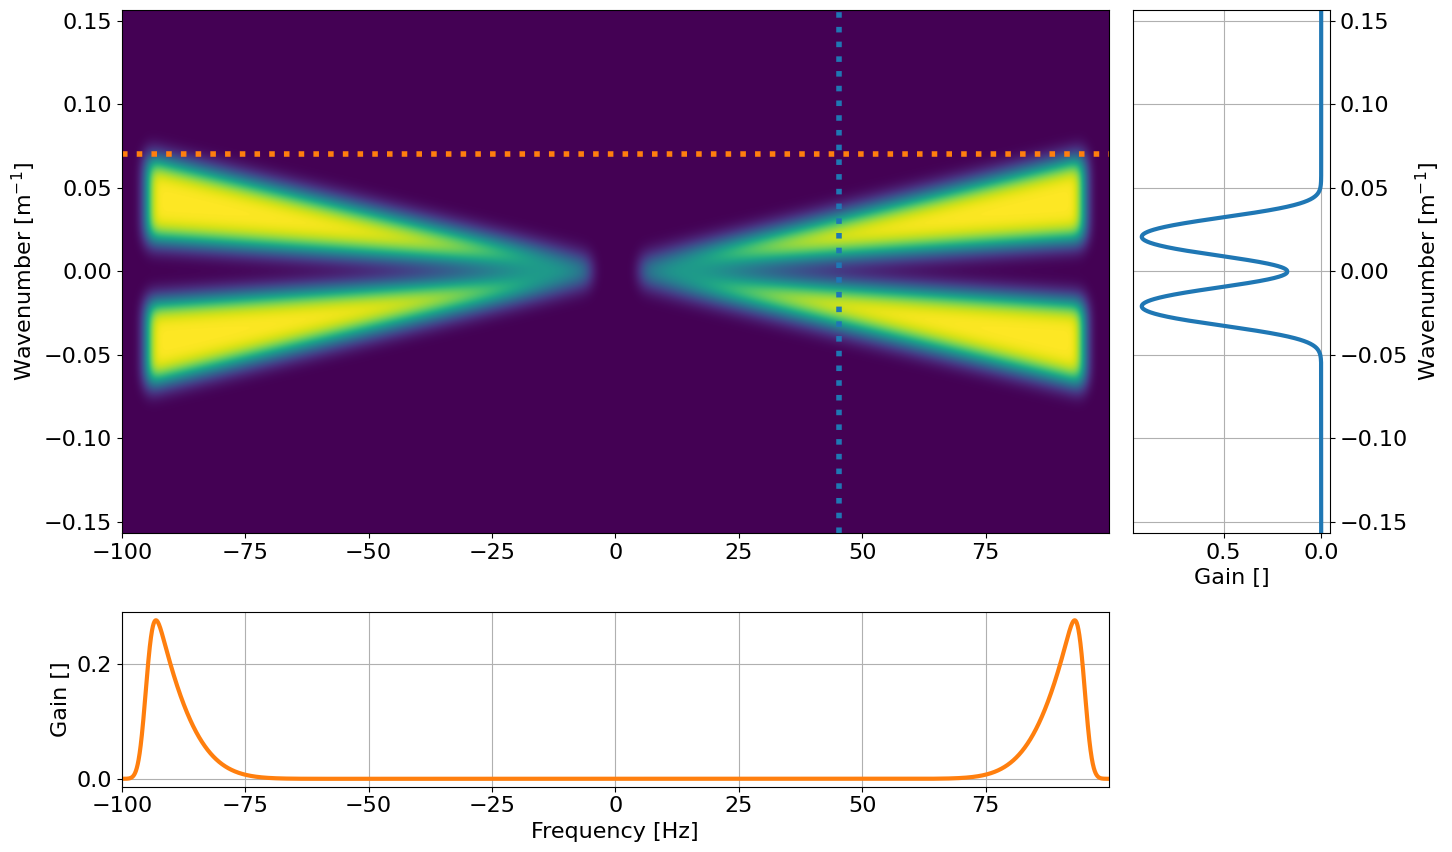

In [12]:
# Set the wanted parameters for the f-k filter
fk_params_s = {
    'c_min': 1400., # m.s-1
    'c_max': 5000., # m.s-1
    'fmin': 5., # Hz
    'fmax': 95. # Hz
}

fk_filter = dw.dsp.hybrid_ninf_gs_filter_design((tr.shape[0],tr.shape[1]), selected_channels, dx, fs, fk_params_s, display_filter=True)
trf_fk = dw.dsp.fk_filter_sparsefilt(tr, fk_filter, tapering=False)

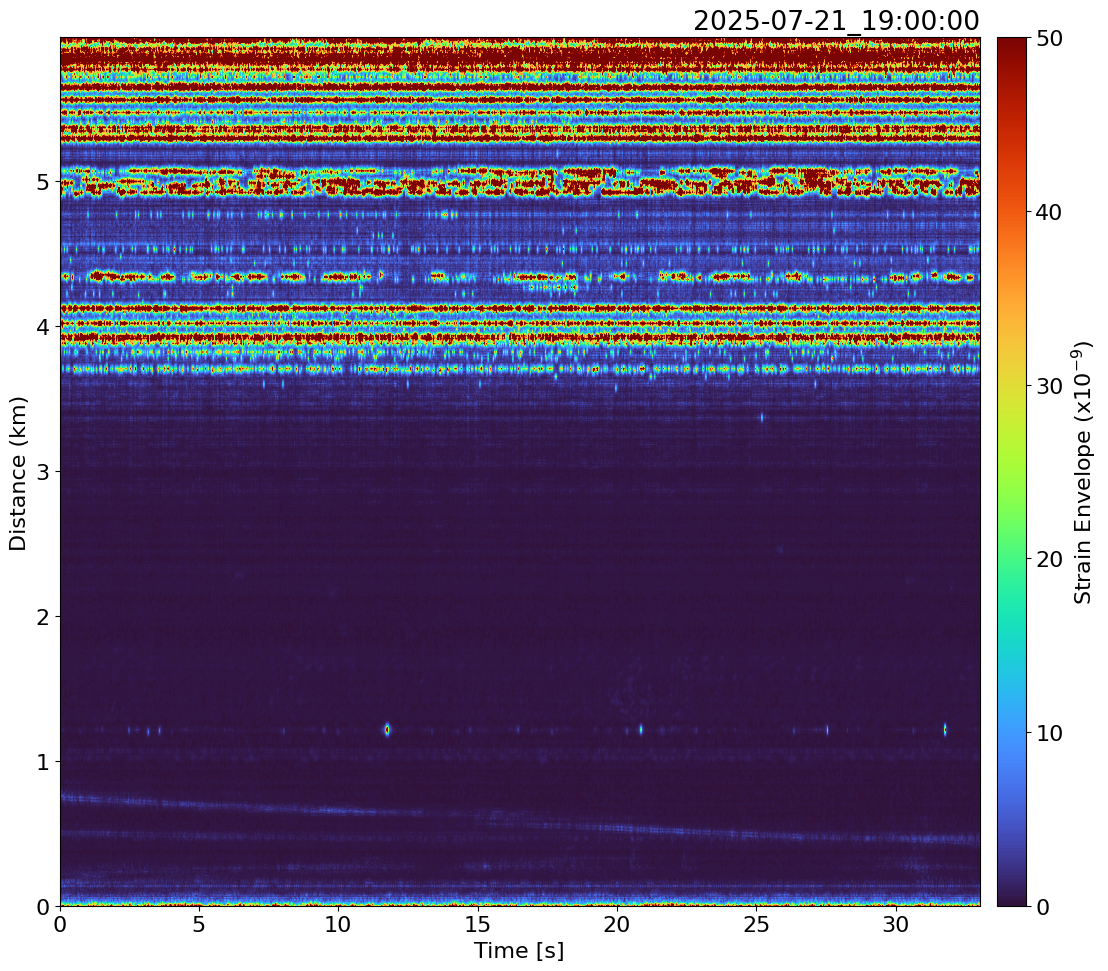

In [13]:
dw.plot.plot_tx(sp.hilbert(trf_fk, axis=1), time, dist, metadata["fileBeginTimeUTC"], fig_size=(12, 10), v_min=0, v_max=50)

## Display channels 

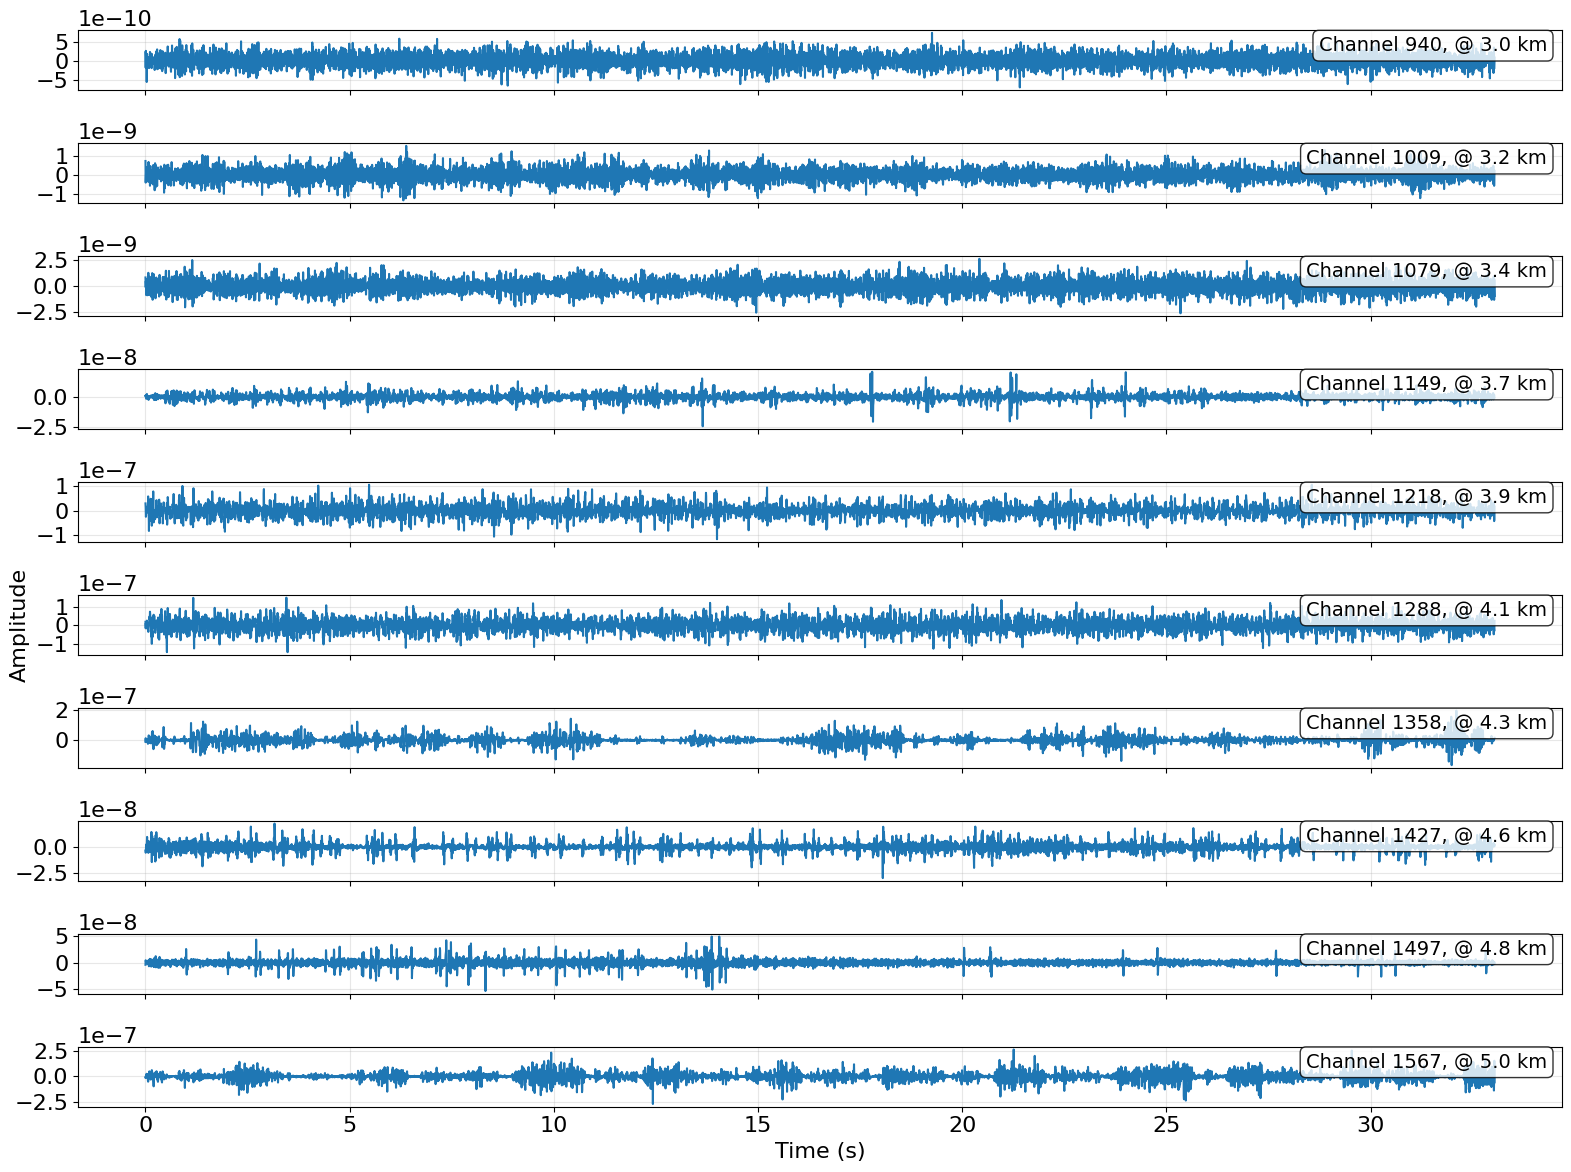

In [15]:
# Distance to channels number, every 10 channels
channel_array = [int(chan) for chan in np.linspace(int(3000/dx), int(5000/dx), 10)]

# Create a figure with subplots for each channel
fig, axes = plt.subplots(len(channel_array), 1, figsize=(16, 12), 
                        sharex=True)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.15)

# Plot each channel
for i, channel in enumerate(channel_array):
    axes[i].plot(time, trf_fk[channel, :])
    
    # Add title in a box in upper right corner
    title_text = f'Channel {channel}, @ {channel * dx / 1e3:.1f} km'
    axes[i].text(0.99, 0.9, title_text, 
                transform=axes[i].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', 
                         edgecolor='black', alpha=0.8),
                verticalalignment='top',
                horizontalalignment='right',
                fontsize=14)
    
    axes[i].grid(True, alpha=0.3)

    # Show x-label on bottom subplot
    if i == len(channel_array) - 1:
        axes[i].set_xlabel('Time (s)')
    
    if i == len(channel_array) // 2:
        axes[i].set_ylabel('Amplitude')

# Set shared x-axis limits if needed
# axes[0].set_xlim(time.min(), time.max())

plt.tight_layout()
plt.show()


## Match-filter with template (source) signal

In [16]:
# Requires librosa library
import librosa

In [17]:
src_file = 'data/VDAS_test2_SRKW.wav'
src_file = 'data/VDAS_test2_synthetic_only.wav'
audio_data, sample_rate = librosa.load(src_file, sr=None)  # sr=None preserves original sample rate
time_audio = np.arange(len(audio_data)) / sample_rate

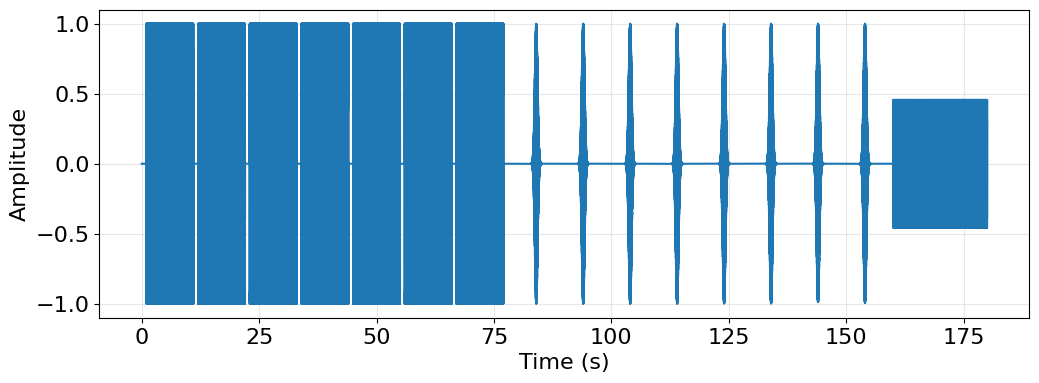

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(time_audio, audio_data)
plt.grid(True, alpha=0.3)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [20]:
# Match-filter the data with the source signal
w_audio_data = np.hanning(len(audio_data)) * audio_data  # Apply a Hann window to the audio data
nmf_tr = dw.detect.calc_nmf_correlogram(trf_fk[channel_array, :], audio_data)

100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


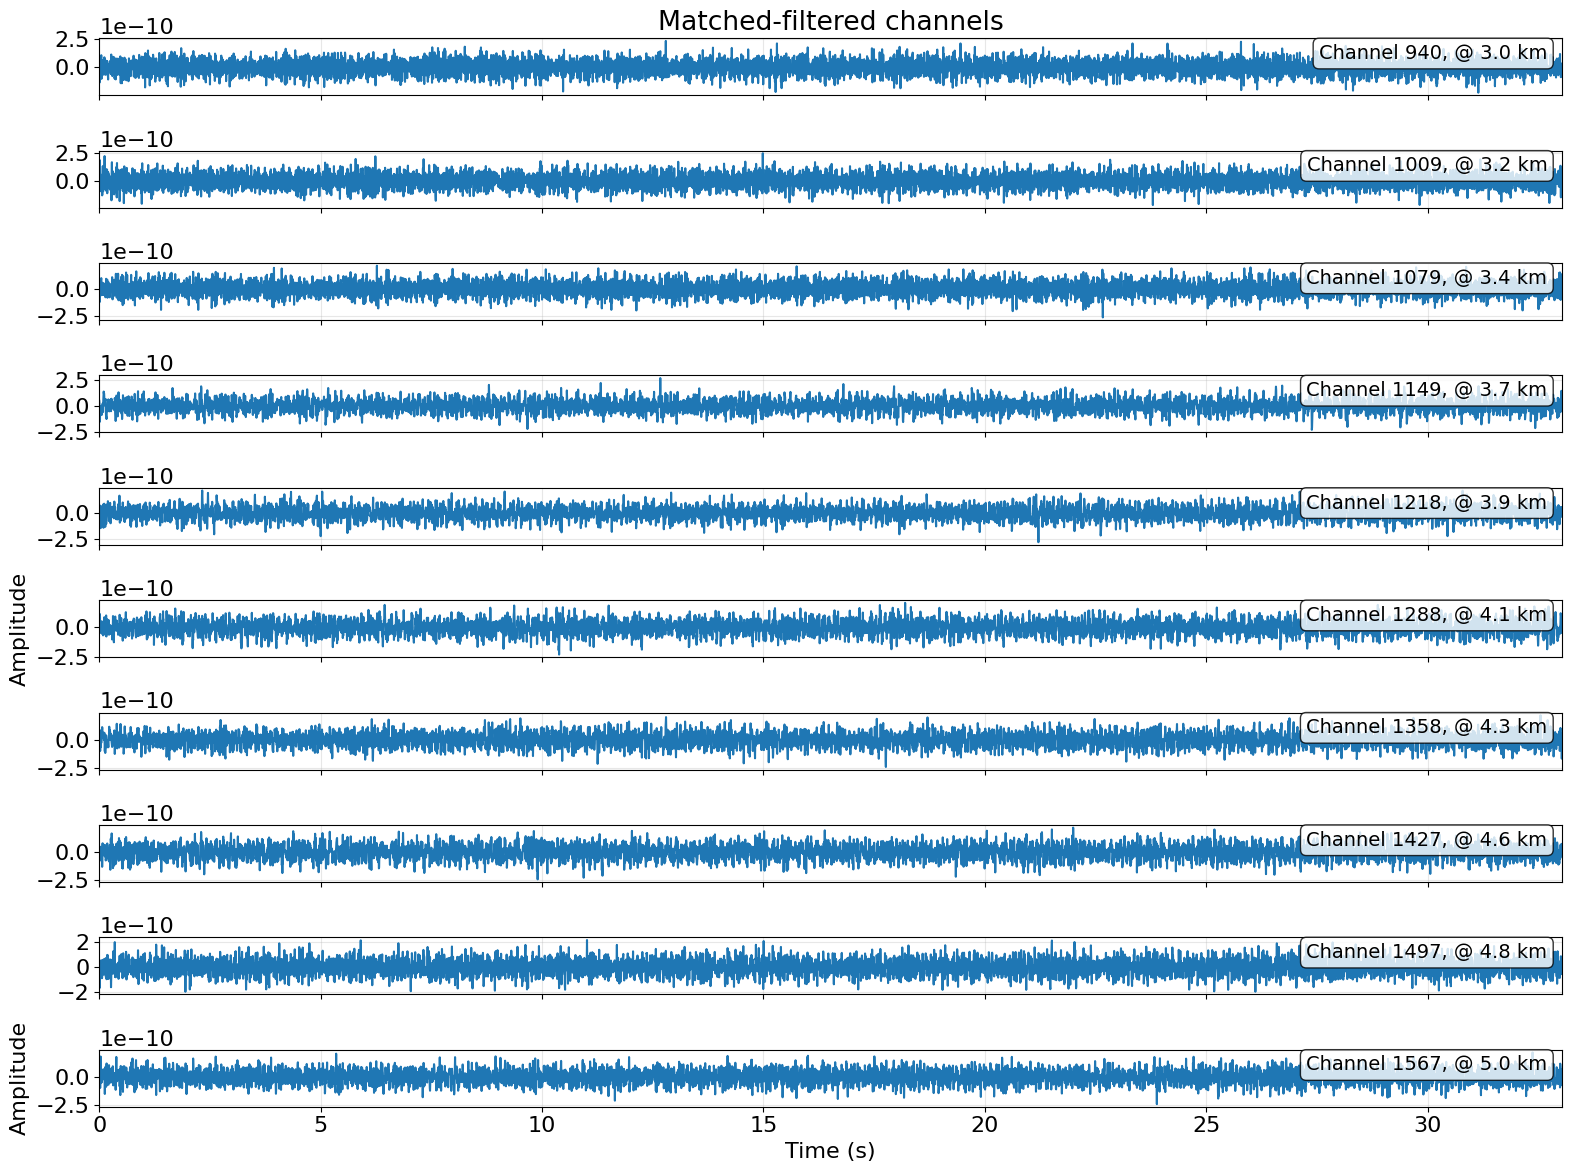

In [25]:
# Plot the matched-filtered channels
fig, ax = plt.subplots(len(channel_array), 1, figsize=(16, 12), 
                        sharex=True)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.15)    
# Plot each channel
for i, nmf in enumerate(nmf_tr):
    ax[i].plot(time, nmf)
    
    # Add title in a box in upper right corner
    title_text = f'Channel {channel_array[i]}, @ {channel_array[i] * dx / 1e3:.1f} km'
    ax[i].text(0.99, 0.9, title_text,
               transform=ax[i].transAxes,
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                         edgecolor='black', alpha=0.8),
               verticalalignment='top',
               horizontalalignment='right',
               fontsize=14)
    ax[i].grid(True, alpha=0.3)
    # Show x-label on bottom subplot
    if i == len(channel_array) - 1:
        ax[i].set_xlabel('Time (s)')
        ax[i].set_ylabel('Amplitude')
    if i == len(channel_array) // 2:
        ax[i].set_ylabel('Amplitude')

ax[0].set_title('Matched-filtered channels')
ax[0].set_xlim(time.min(), time.max())
plt.tight_layout()
plt.show()
